# ML Models
### Author: Omar Alamssi

In [ ]:
!pip -q install statsmodels scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")



In [ ]:
DATA_PATH = "preprocessed_data_2010_2025.csv"   # change if needed
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Shape: (139032, 37)
Columns: ['Datetime', 'Temperature', 'Wind Speed', 'Condition_Blowing Sand', 'Condition_Cloudy', 'Condition_Drizzle', 'Condition_Duststorm', 'Condition_Fair', 'Condition_Fog', 'Condition_Freezing Rain', 'Condition_Hail', 'Condition_Haze', 'Condition_Heavy Drizzle', 'Condition_Heavy Rain', 'Condition_Heavy Snow', 'Condition_Light Drizzle', 'Condition_Light Rain', 'Condition_Light Snow', 'Condition_Mist', 'Condition_Mostly Cloudy', 'Condition_Partial Fog', 'Condition_Partly Cloudy', 'Condition_Rain', 'Condition_Rain Shower', 'Condition_Sand', 'Condition_Sandstorm', 'Condition_Sleet', 'Condition_Small Hail', 'Condition_Smoke', 'Condition_Snow', 'Condition_Snow Grains', 'Condition_Squalls', 'Condition_Thunder', 'Condition_Widespread Dust', 'Condition_Wintry Mix', 'WindDir_sin', 'WindDir_cos']


,Datetime,Temperature,Wind Speed,Condition_Blowing Sand,Condition_Cloudy,Condition_Drizzle,Condition_Duststorm,Condition_Fair,Condition_Fog,Condition_Freezing Rain,...,Condition_Small Hail,Condition_Smoke,Condition_Snow,Condition_Snow Grains,Condition_Squalls,Condition_Thunder,Condition_Widespread Dust,Condition_Wintry Mix,WindDir_sin,WindDir_cos
0,2010-01-01 00:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.866025,-4.999999e-01
1,2010-01-01 01:00:00,10.000000,6.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-1.000000,1.192488e-08
2,2010-01-01 02:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
3,2010-01-01 03:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
4,2010-01-01 04:00:00,11.111111,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01


In [ ]:
date_col = "Datetime"
target_col = "Temperature"
sin_col = "WindDir_sin"

# cosine variant
if "WindDir_cos" in df.columns:
    cos_col = "WindDir_cos"
elif "WindDir_COS" in df.columns:
    cos_col = "WindDir_COS"
else:
    cos_col = None

# wind speed variant list
wind_candidates = ["WindSpeed", "Wind_Speed", "Wind Speed", "WindSpeed_mps", "WindSpeed_ms", "WindSpeed_kmh"]
wind_col = next((c for c in wind_candidates if c in df.columns), None)

required = [date_col, target_col, sin_col, cos_col, wind_col]
missing = [c for c in required if c is None or c not in df.columns]
assert not missing, f"❌ Missing required columns: {missing}\nAvailable: {df.columns.tolist()}"

print("Using columns:")
print("Datetime:", date_col)
print("Target:", target_col)
print("Features:", [sin_col, cos_col, wind_col])

Using columns:
Datetime: Datetime
Target: Temperature
Features: ['WindDir_sin', 'WindDir_cos', 'Wind Speed']


In [ ]:
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

df_req = df[[target_col, sin_col, cos_col, wind_col]].copy()

# Ensure numeric
for c in df_req.columns:
    df_req[c] = pd.to_numeric(df_req[c], errors="coerce")

df_req = df_req.ffill().bfill()

# Enforce hourly series
df_hourly = df_req.resample("H").mean().ffill().bfill()

print("Hourly shape:", df_hourly.shape)
print("Range:", df_hourly.index.min(), "→", df_hourly.index.max())
display(df_hourly.head())


Hourly shape: (140136, 4)
Range: 2010-01-01 00:00:00 → 2025-12-26 23:00:00


,Temperature,WindDir_sin,WindDir_cos,Wind Speed
Datetime,,,,
2010-01-01 00:00:00,10.000000,-0.866025,-4.999999e-01,7.0
2010-01-01 01:00:00,10.000000,-1.000000,1.192488e-08,6.0
2010-01-01 02:00:00,10.000000,-0.939693,-3.420201e-01,7.0
2010-01-01 03:00:00,10.000000,-0.939693,-3.420201e-01,7.0
2010-01-01 04:00:00,11.111111,-0.939693,-3.420201e-01,7.0


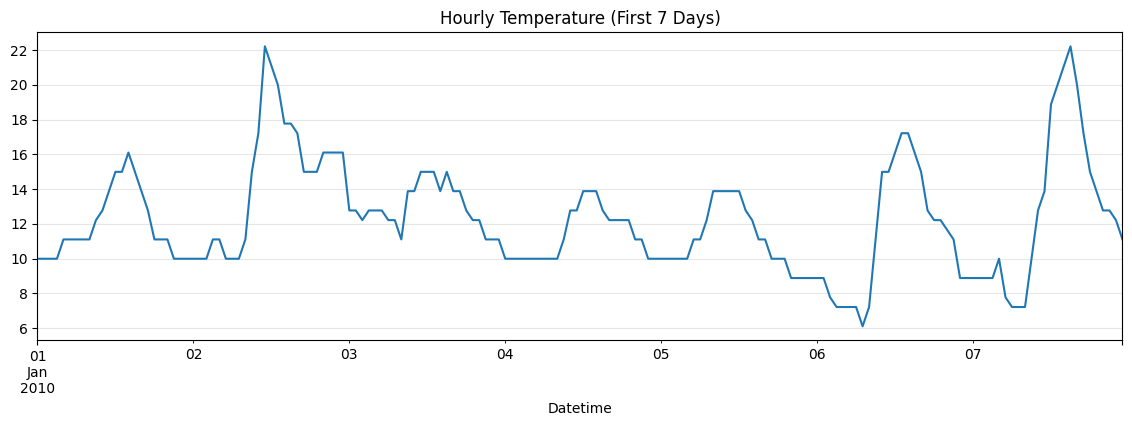

In [ ]:
plt.figure(figsize=(14,4))
df_hourly[target_col].iloc[:24*7].plot()
plt.title("Hourly Temperature (First 7 Days)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
def add_temp_lags(df, target, lags=(1, 3, 24, 168)):
    out = df.copy()
    for l in lags:
        out[f"{target}_lag_{l}"] = out[target].shift(l)
    return out.dropna()

TEMP_LAGS = (1, 3, 24, 168)  # previous 1h, 3h, 24h (daily), 168h (weekly)
df_seq = add_temp_lags(df_hourly, target_col, lags=TEMP_LAGS)

print("After adding sequence lags:", df_seq.shape)
display(df_seq.head())


After adding sequence lags: (139968, 8)


,Temperature,WindDir_sin,WindDir_cos,Wind Speed,Temperature_lag_1,Temperature_lag_3,Temperature_lag_24,Temperature_lag_168
Datetime,,,,,,,,
2010-01-08 00:00:00,11.111111,0.0,1.0,0.0,11.111111,12.777778,8.888889,10.000000
2010-01-08 01:00:00,8.888889,0.0,1.0,0.0,11.111111,12.222222,8.888889,10.000000
2010-01-08 02:00:00,8.888889,0.0,1.0,0.0,8.888889,11.111111,8.888889,10.000000
2010-01-08 03:00:00,8.888889,0.0,1.0,0.0,8.888889,11.111111,8.888889,10.000000
2010-01-08 04:00:00,7.777778,0.0,1.0,0.0,8.888889,8.888889,10.000000,11.111111


In [ ]:
SPLIT_RATIO = 0.8
split_idx = int(len(df_seq) * SPLIT_RATIO)

train_df = df_seq.iloc[:split_idx].copy()
test_df  = df_seq.iloc[split_idx:].copy()

y_train = train_df[target_col]
y_test  = test_df[target_col]

# SAME intake for SVR + Regression: wind features + temp lag sequence
feature_cols = (
    [sin_col, cos_col, wind_col] +
    [f"{target_col}_lag_{l}" for l in TEMP_LAGS]
)

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Number of features:", X_train.shape[1])
print("Features:", feature_cols)
print("Train end:", train_df.index.max(), "| Test start:", test_df.index.min())
assert train_df.index.max() < test_df.index.min()


Train rows: 111974 Test rows: 27994
Number of features: 7
Features: ['WindDir_sin', 'WindDir_cos', 'Wind Speed', 'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_24', 'Temperature_lag_168']
Train end: 2022-10-17 13:00:00 | Test start: 2022-10-17 14:00:00


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()


In [ ]:
svm = LinearSVR(C=1.0, epsilon=0.1, random_state=42, max_iter=30000)
svm.fit(X_train_scaled, y_train_scaled)

svm_pred_scaled = svm.predict(X_test_scaled)
svm_pred = scaler_y.inverse_transform(svm_pred_scaled.reshape(-1,1)).ravel()
svm_pred = pd.Series(svm_pred, index=y_test.index)

print("SVM (LinearSVR) done ✅")


SVM (LinearSVR) done ✅


In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
lr_pred = scaler_y.inverse_transform(lr.predict(X_test_scaled).reshape(-1,1)).ravel()
lr_pred = pd.Series(lr_pred, index=y_test.index)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train_scaled)
ridge_pred = scaler_y.inverse_transform(ridge.predict(X_test_scaled).reshape(-1,1)).ravel()
ridge_pred = pd.Series(ridge_pred, index=y_test.index)

print("Regression done ✅")


Regression done ✅


In [ ]:
m = 24  # daily cycle for hourly data

sarimax = SARIMAX(
    y_train,
    exog=train_df[[sin_col, cos_col, wind_col]],
    order=(0,0,0),
    seasonal_order=(0,0,0,m),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax.fit(disp=False)

sarimax_pred = sarimax_fit.forecast(
    steps=len(y_test),
    exog=test_df[[sin_col, cos_col, wind_col]]
)

sarimax_pred = pd.Series(np.asarray(sarimax_pred), index=y_test.index)

print("SARIMAX done ✅")


SARIMAX done ✅


In [ ]:
def evaluate(y_true, y_pred, name):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"Model": name, "MAE": mae, "RMSE": rmse}

results = [
    evaluate(y_test, svm_pred, "SVM (LinearSVR, seq + wind)"),
    evaluate(y_test, sarimax_pred, "SARIMAX (wind exog)"),
    evaluate(y_test, lr_pred, "Linear Regression (seq + wind)"),
    evaluate(y_test, ridge_pred, "Ridge Regression (seq + wind)")
]

results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)


,Model,MAE,RMSE
0,"SVM (LinearSVR, seq + wind)",0.769155,1.052209
2,Linear Regression (seq + wind),0.770768,1.053251
3,Ridge Regression (seq + wind),0.770778,1.053255
1,SARIMAX (wind exog),9.714020,12.298467


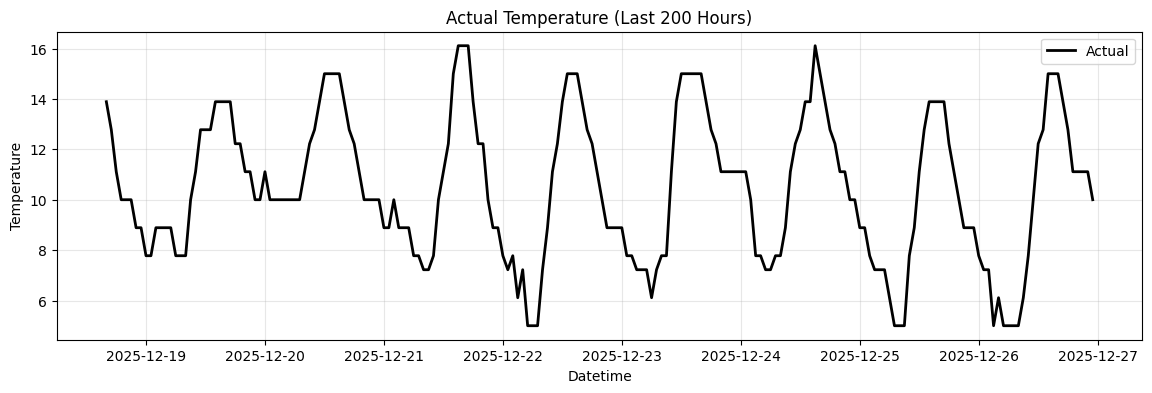

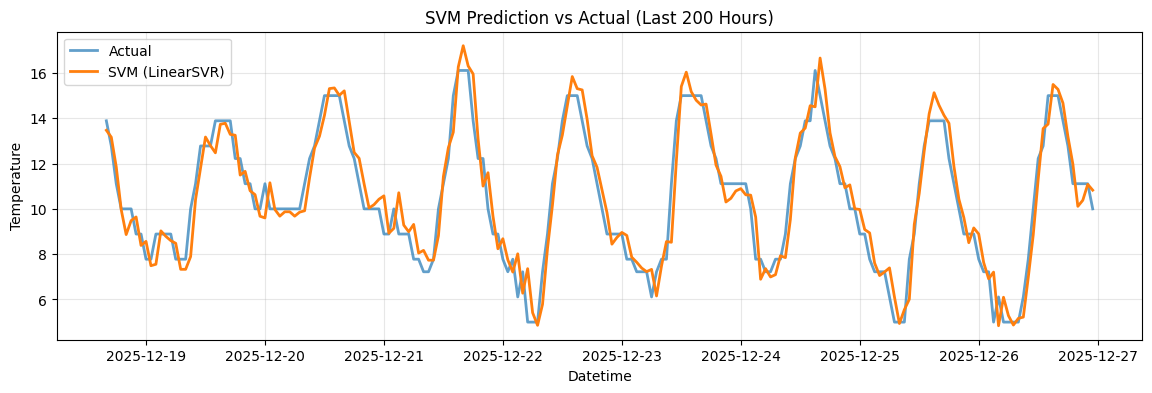

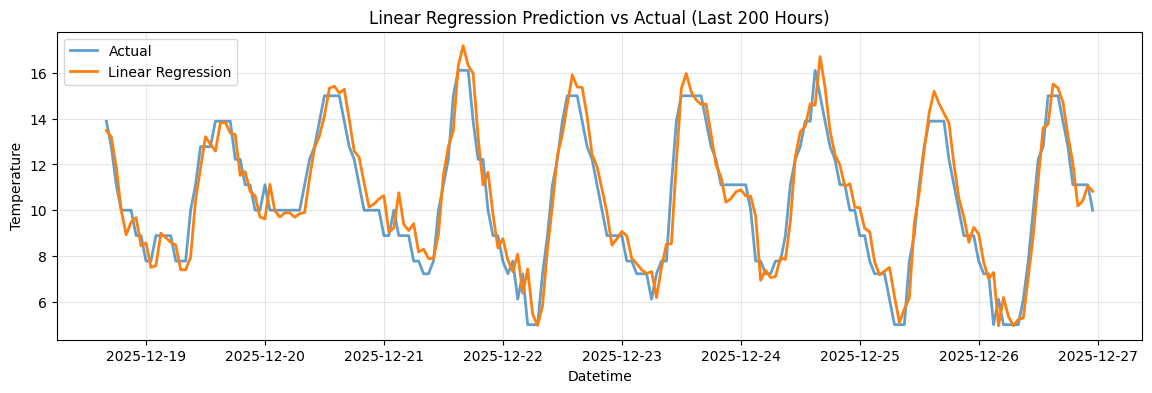

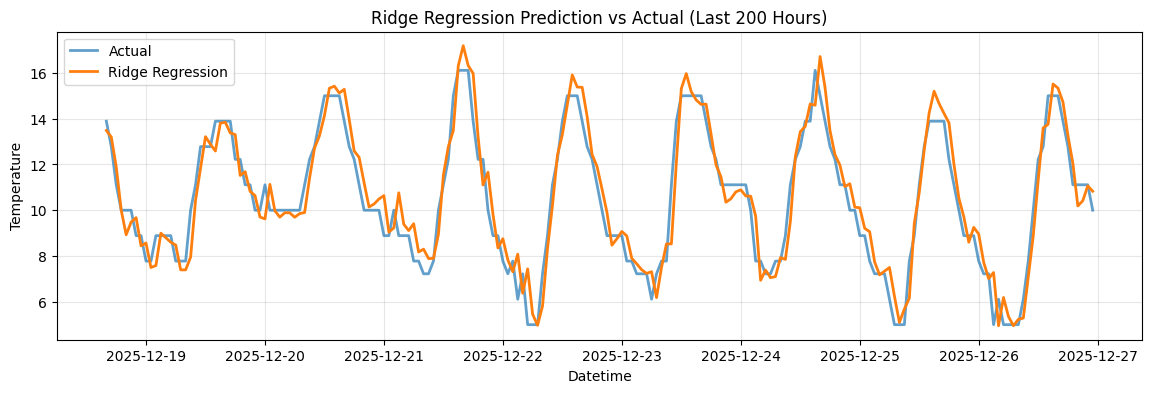

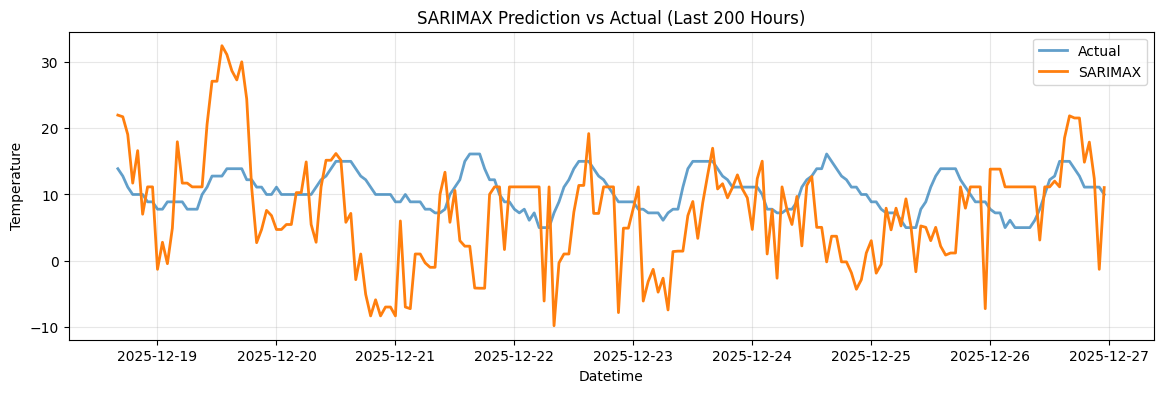

In [ ]:
N = 200
idx = y_test.index[-N:]

actual = y_test.iloc[-N:]
svm_p  = svm_pred.iloc[-N:]
lr_p   = lr_pred.iloc[-N:]
ridge_p = ridge_pred.iloc[-N:]
sar_p  = sarimax_pred.iloc[-N:]
#📌 1️⃣ Actual Temperature

plt.figure(figsize=(14,4))
plt.plot(idx, actual.values, label="Actual", linewidth=2, color="black")
plt.title("Actual Temperature (Last 200 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
#📌 2️⃣ SVM (Sequence-based)

plt.figure(figsize=(14,4))
plt.plot(idx, actual.values, label="Actual", linewidth=2, alpha=0.7)
plt.plot(idx, svm_p.values, label="SVM (LinearSVR)", linewidth=2)
plt.title("SVM Prediction vs Actual (Last 200 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
#📌 3️⃣ Linear Regression (Sequence-based)

plt.figure(figsize=(14,4))
plt.plot(idx, actual.values, label="Actual", linewidth=2, alpha=0.7)
plt.plot(idx, lr_p.values, label="Linear Regression", linewidth=2)
plt.title("Linear Regression Prediction vs Actual (Last 200 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
#📌 4️⃣ Ridge Regression (Sequence-based)

plt.figure(figsize=(14,4))
plt.plot(idx, actual.values, label="Actual", linewidth=2, alpha=0.7)
plt.plot(idx, ridge_p.values, label="Ridge Regression", linewidth=2)
plt.title("Ridge Regression Prediction vs Actual (Last 200 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
#📌 5️⃣ SARIMAX (Hourly, with wind exogenous variables)

plt.figure(figsize=(14,4))
plt.plot(idx, actual.values, label="Actual", linewidth=2, alpha=0.7)
plt.plot(idx, sar_p.values, label="SARIMAX", linewidth=2)
plt.title("SARIMAX Prediction vs Actual (Last 200 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
pred_df = pd.DataFrame({
    "actual": y_test,
    "svm_seq": svm_pred,
    "sarimax": sarimax_pred,
    "linear_reg_seq": lr_pred,
    "ridge_seq": ridge_pred
})

pred_df.to_csv("hourly_predictions_sequence_models.csv")
print("Saved: hourly_predictions_sequence_models.csv")


Saved: hourly_predictions_sequence_models.csv
